In [6]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
blue = '#1F449C'
pink = '#E57A77'

In [35]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20, 10],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            {'name': 'mu2', 'type': 'normfactor', 'data': None}]},
        {'name': 'background',
        'data': [120, 110, 100],
        'modifiers': [
            # Normalisation Uncertainty / Normal
            {'name': 'normSys', "type": "normsys", "data": {"hi": 0.95, "lo": 1.05}},
            # Staterror / Normal
            {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
            # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]}
            ]}]}]
            }
        )

data = [110, 105, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu2': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

In [15]:
with open('ttbar_ljets_xsec_inclusive_pruned.json') as serialized:
    spec = json.load(serialized)

workspace = pyhf.Workspace(spec)
model = workspace.model()

data = workspace.data(model, include_auxdata=False)

unconstr_priors = {
    'ttbarXsec': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]}
}

In [14]:
model.config.poi_name

'ttbarXsec'

In [16]:
priorDict_conjugate = prepare_inference.build_priorDict_conjugate(model, unconstr_priors)
len(priorDict_conjugate.keys())

98

In [26]:
pyhf.set_backend('jax')
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=1_00, chains=1_00, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1_00)

Only 100 samples in chain.
Multiprocess sampling (100 chains in 4 jobs)
CompoundStep
>Metropolis: [JET_JER_DataVsMC]
>Metropolis: [JET_JER_NP1]
>Metropolis: [JET_JER_NP2]
>Metropolis: [JET_JER_NP3]
>Metropolis: [JET_JER_NP4]
>Metropolis: [JET_JER_NP7]
>Metropolis: [weight_bTagSF_MV2c10_Continuous_eigenvars_C_0]
>Metropolis: [weight_bTagSF_MV2c10_Continuous_eigenvars_C_1]
>Metropolis: [weight_bTagSF_MV2c10_Continuous_eigenvars_Light_0]
>Metropolis: [weight_bTagSF_MV2c10_Continuous_eigenvars_Light_1]
>Metropolis: [weight_jvt]
>Metropolis: [weight_pileup]
>Metropolis: [MultijetNorm_SR1_ejets]
>Metropolis: [MultijetNorm_SR1_mujets]
>Metropolis: [MultijetShape_SR1_mujets]
>Metropolis: [JET_EtaIntercalibration_Modelling]
>Metropolis: [JET_Flavor_Response]
>Metropolis: [JET_Pileup_RhoTopology]
>Metropolis: [ttbar_FSR_Model_SR1]
>Metropolis: [ttbar_ISR_Model_Var3c_SR1]
>Metropolis: [ttbar_ISR_Model_hdamp]
>Metropolis: [ttbar_ISR_Model_muF_SR1]
>Metropolis: [ttbar_ISR_Model_muR_SR1]
>Metropolis

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),
/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/pymc/step_methods/metropolis.py:287: RuntimeWarning: overflow encountered in exp
  "accept": 

Sampling: [Expected_Data, JET_BJES_Response, JET_EffectiveNP_Detector1, JET_EffectiveNP_Mixed1, JET_EffectiveNP_Mixed2, JET_EffectiveNP_Modelling1, JET_EffectiveNP_Modelling2, JET_EffectiveNP_Modelling3, JET_EffectiveNP_Statistical1, JET_EffectiveNP_Statistical2, JET_EtaIntercalibration_Modelling, JET_EtaIntercalibration_TotalStat, JET_Flavor_Composition, JET_Flavor_Response, JET_JER_DataVsMC, JET_JER_NP1, JET_JER_NP2, JET_JER_NP3, JET_JER_NP4, JET_JER_NP5, JET_JER_NP6, JET_JER_NP7, JET_Pileup_OffsetMu, JET_Pileup_OffsetNPV, JET_Pileup_RhoTopology, Lumi, MET_SoftTrk_ResoPara, MET_SoftTrk_ResoPerp, MET_SoftTrk_Scale, MultijetNorm_SR1_ejets, MultijetNorm_SR1_mujets, MultijetNorm_SR2_ejets, MultijetNorm_SR2_mujets, MultijetNorm_SR3_ejets, MultijetNorm_SR3_mujets, MultijetShape_SR1_mujets, MultijetShape_SR2_ejets, MultijetShape_SR2_mujets, MultijetShape_SR3_ejets, MultijetShape_SR3_mujets, OtherNorm, STop_DR_DS_Model, STop_FSR_Model, STop_ISR_Model_Var3c, STop_ISR_Model_muF, STop_ISR_Model

/Users/malinhorstmann/anaconda3/envs/pyhf_pymc/lib/python3.9/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (98), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'JET_JER_DataVsMC'}>,
        <AxesSubplot: title={'center': 'JET_JER_DataVsMC'}>],
       [<AxesSubplot: title={'center': 'JET_JER_NP1'}>,
        <AxesSubplot: title={'center': 'JET_JER_NP1'}>],
       [<AxesSubplot: title={'center': 'JET_JER_NP2'}>,
        <AxesSubplot: title={'center': 'JET_JER_NP2'}>],
       [<AxesSubplot: title={'center': 'JET_JER_NP3'}>,
        <AxesSubplot: title={'center': 'JET_JER_NP3'}>],
       [<AxesSubplot: title={'center': 'JET_JER_NP4'}>,
        <AxesSubplot: title={'center': 'JET_JER_NP4'}>],
       [<AxesSubplot: title={'center': 'JET_JER_NP7'}>,
        <AxesSubplot: title={'center': 'JET_JER_NP7'}>],
       [<AxesSubplot: title={'center': 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_0'}>,
        <AxesSubplot: title={'center': 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_0'}>],
       [<AxesSubplot: title={'center': 'weight_bTagSF_MV2c10_Continuous_eigenvars_C_1'}>,
        <AxesSubplot: title={'center': 'w

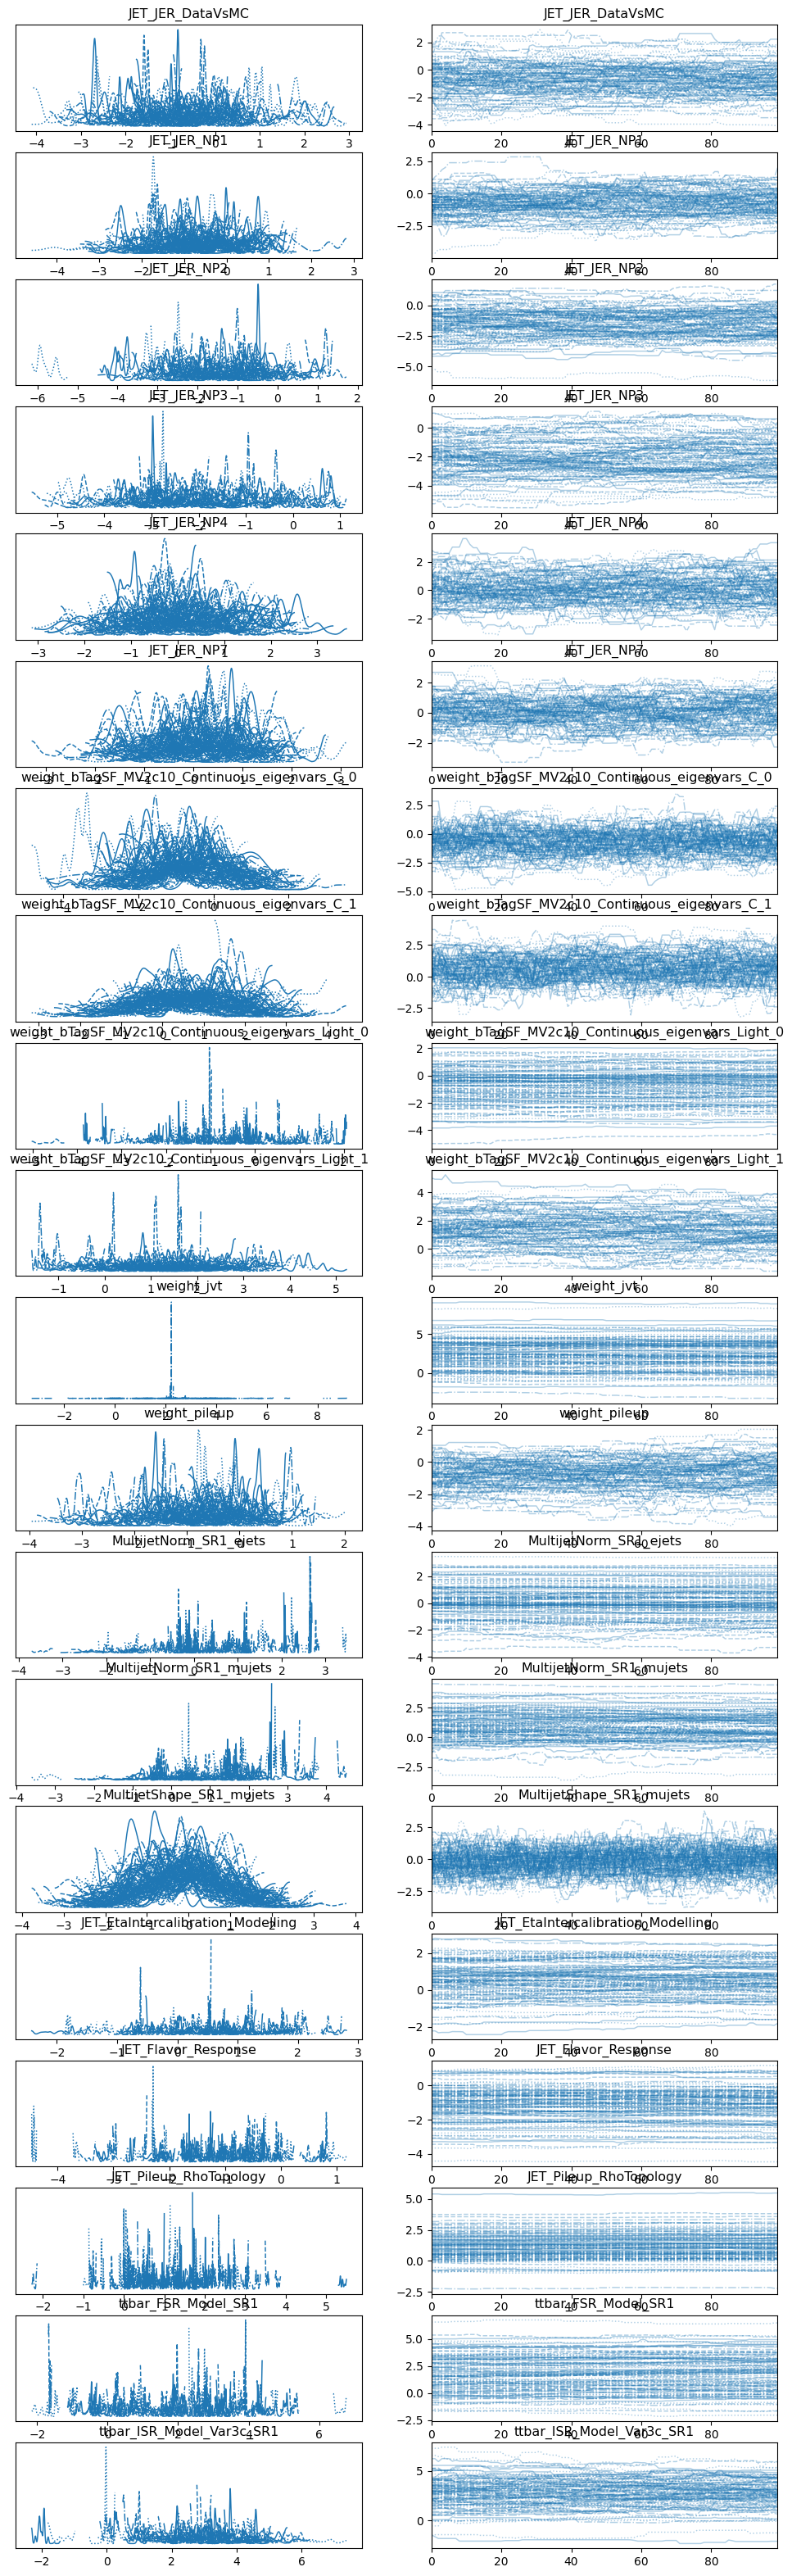

In [27]:
az.plot_trace(post_data)

In [19]:
prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

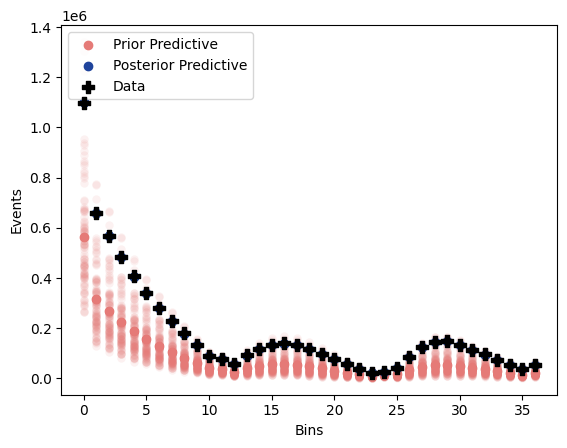

In [28]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)

In [29]:
a = corner.corner(post_data.posterior, quantiles=[0.5], color = blue);

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x15e6b43a0> (for post_execute):


KeyboardInterrupt: 